# SFT

## Load data

In [4]:
import os
import json
import wandb
import pandas as pd
from pathlib import Path

### Evaluation results

In [5]:
def load_result_file(result_file: str):
    with open(result_file, "r") as f:
        return json.load(f)

results_df = pd.DataFrame.from_records(
    load_result_file(result_file)
    for eval_folder in os.scandir(Path(os.getcwd()).parent / "results")
    for result_file in os.scandir(eval_folder)
    if result_file.name.startswith("results")
)

results_df.head()

,dataset,model_A,model_B,judge_model,num_battles,winrate,num_wins,num_losses,num_ties,preferences,date,user
0,alpaca-eval,VLLM//home/hk-project-p0024002/fr_ae293/work/h...,VLLM/meta-llama/Llama-3.1-8B-Instruct,VLLM/Qwen/Qwen2.5-32B-Instruct-GPTQ-Int8,805,0.259627,209,535,61,"[0.7109495026250039, 0.8175744761936437, 0.109...",2025-10-23T14:19:01.612525,fr_ae293
1,alpaca-eval,VLLM//home/hk-project-p0024002/fr_ae293/work/h...,VLLM/meta-llama/Llama-3.1-8B-Instruct,VLLM/Qwen/Qwen2.5-32B-Instruct-GPTQ-Int8,805,0.265839,214,535,56,"[0.6456563062257954, 0.5744425168116589, 0.574...",2025-10-23T11:08:31.375302,fr_ae293
2,alpaca-eval,VLLM//home/hk-project-p0024002/fr_ae293/work/h...,VLLM/meta-llama/Llama-3.1-8B-Instruct,VLLM/Qwen/Qwen2.5-32B-Instruct-GPTQ-Int8,805,0.216149,174,582,49,"[0.7109495026250039, 0.8175744761936437, 0.645...",2025-10-23T12:26:15.037230,fr_ae293
3,alpaca-eval,VLLM//home/hk-project-p0024002/fr_ae293/work/h...,VLLM/meta-llama/Llama-3.1-8B-Instruct,VLLM/Qwen/Qwen2.5-32B-Instruct-GPTQ-Int8,805,0.216149,174,552,79,"[0.6456563062257954, 0.2890504973749961, 0.645...",2025-10-23T10:10:41.097654,fr_ae293
4,alpaca-eval,VLLM//home/hk-project-p0024002/fr_ae293/work/h...,VLLM/meta-llama/Llama-3.1-8B-Instruct,VLLM/Qwen/Qwen2.5-32B-Instruct-GPTQ-Int8,805,0.274534,221,522,62,"[0.6456563062257954, 0.7685247834990176, 0.645...",2025-10-23T10:30:04.994650,fr_ae293


### Training results

In [6]:
wandb_api = wandb.Api(api_key="206ad9f8184b902f52c17b837fc662a2432f26a6")
wandb_run_part1 = wandb_api.run("/ali-elganzory-university-of-freiburg/openeurollm/runs/9bibiyt9")
wandb_run_part2 = wandb_api.run("/ali-elganzory-university-of-freiburg/openeurollm/runs/v505adta")

In [7]:
wandb_history_part1 = wandb_run_part1.scan_history()
wandb_history_part2 = wandb_run_part2.scan_history()

train_results_df = (
    pd.concat(
        [
            pd.DataFrame.from_records(wandb_history_part1),
            pd.DataFrame.from_records(wandb_history_part2),
        ]
    )
    .drop_duplicates(subset="_step", keep="last")
    .sort_values(by="_step")
    .reset_index(drop=True)
)
train_results_df.head()

,total_tokens_including_padding,per_device_tps_including_padding,avg_pred_tokens_per_batch,total_tokens,per_device_tps,avg_tokens_per_batch,avg_tokens_per_batch_including_padding,reserved_mem_GiB,_runtime,learning_rate,total_pred_tokens,allocated_mem_GiB,total_tokens_this_log_period,_timestamp,train_loss,_step
0,88732.0,1659.922543,501.656250,88732.0,1659.922602,693.218750,693.218750,63.164062,64.482913,1.140901e-08,64212.0,36.226859,88732,1.760769e+09,1.192281,1
1,165668.0,1683.753582,449.847656,165668.0,1683.753631,647.140625,647.140625,63.164062,76.197583,2.281803e-08,115161.0,51.553961,76936,1.760769e+09,1.105380,2
2,252469.0,1736.356513,456.445312,252469.0,1736.356535,657.471354,657.471354,72.929688,88.887694,3.422704e-08,175275.0,63.463338,86801,1.760769e+09,1.142651,3
3,343760.0,1752.402800,468.488281,343760.0,1752.402809,671.406250,671.406250,72.929688,101.522915,4.563605e-08,239866.0,63.463338,91291,1.760769e+09,1.061574,4
4,438180.0,1777.251809,475.851562,438180.0,1777.251816,684.656250,684.656250,74.861328,112.612923,5.704507e-08,304545.0,63.463338,94420,1.760769e+09,1.220090,5


In [8]:
len(train_results_df)

14613

## Modify winrate

Ties are not counted as wins or losses. However, as commonly done in the literature, they should be counted as 0.5 wins and 0.5 losses for both models.

In [9]:
results_df["winrate"].mean()

np.float64(0.2515766962811542)

In [10]:
results_df["winrate"] = (results_df["num_wins"] + results_df["num_ties"] / 2) / results_df["num_battles"]

results_df["winrate"].mean()

np.float64(0.3039952826480069)

## Plot over-time performance

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

## Filter results

In [13]:
over_time_df = results_df[results_df["model_A"].str.contains("/model_")]
len(results_df), len(over_time_df)

(79, 73)

## Format & Add training metrics

In [14]:
over_time_df.loc[:, "step"] = over_time_df["model_A"].str.split("/").str[-1].str.split("_").str[1].astype(int)
over_time_df = over_time_df.sort_values(by="step").reset_index(drop=True)

/scratch/ipykernel_1999702/1549137701.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  over_time_df.loc[:, "step"] = over_time_df["model_A"].str.split("/").str[-1].str.split("_").str[1].astype(int)


In [15]:
over_time_df.loc[:, "train_loss"] = train_results_df.loc[over_time_df["step"] - 1, "train_loss"].reset_index(drop=True)
over_time_df.head()


,dataset,model_A,model_B,judge_model,num_battles,winrate,num_wins,num_losses,num_ties,preferences,date,user,step,train_loss
0,alpaca-eval,VLLM//home/hk-project-p0024002/fr_ae293/work/h...,VLLM/meta-llama/Llama-3.1-8B-Instruct,VLLM/Qwen/Qwen2.5-32B-Instruct-GPTQ-Int8,805,0.219255,142,594,69,"[0.6456563062257954, 0.7109495026250039, 0.574...",2025-10-23T12:02:52.899743,fr_ae293,200,0.742888
1,alpaca-eval,VLLM//home/hk-project-p0024002/fr_ae293/work/h...,VLLM/meta-llama/Llama-3.1-8B-Instruct,VLLM/Qwen/Qwen2.5-32B-Instruct-GPTQ-Int8,805,0.227950,150,588,67,"[0.6456563062257954, 0.8175744761936437, 0.182...",2025-10-23T12:45:43.085837,fr_ae293,400,0.725319
2,alpaca-eval,VLLM//home/hk-project-p0024002/fr_ae293/work/h...,VLLM/meta-llama/Llama-3.1-8B-Instruct,VLLM/Qwen/Qwen2.5-32B-Instruct-GPTQ-Int8,805,0.244099,153,565,87,"[0.7109495026250039, 0.6456563062257954, 0.574...",2025-10-23T13:28:43.579820,fr_ae293,600,0.743797
3,alpaca-eval,VLLM//home/hk-project-p0024002/fr_ae293/work/h...,VLLM/meta-llama/Llama-3.1-8B-Instruct,VLLM/Qwen/Qwen2.5-32B-Instruct-GPTQ-Int8,805,0.267702,176,550,79,"[0.6456563062257954, 0.5, 0.5744425168116589, ...",2025-10-23T14:11:11.482995,fr_ae293,800,0.822529
4,alpaca-eval,VLLM//home/hk-project-p0024002/fr_ae293/work/h...,VLLM/meta-llama/Llama-3.1-8B-Instruct,VLLM/Qwen/Qwen2.5-32B-Instruct-GPTQ-Int8,805,0.265217,174,552,79,"[0.6456563062257954, 0.2890504973749961, 0.645...",2025-10-23T10:10:41.097654,fr_ae293,1000,0.773722


## Plot

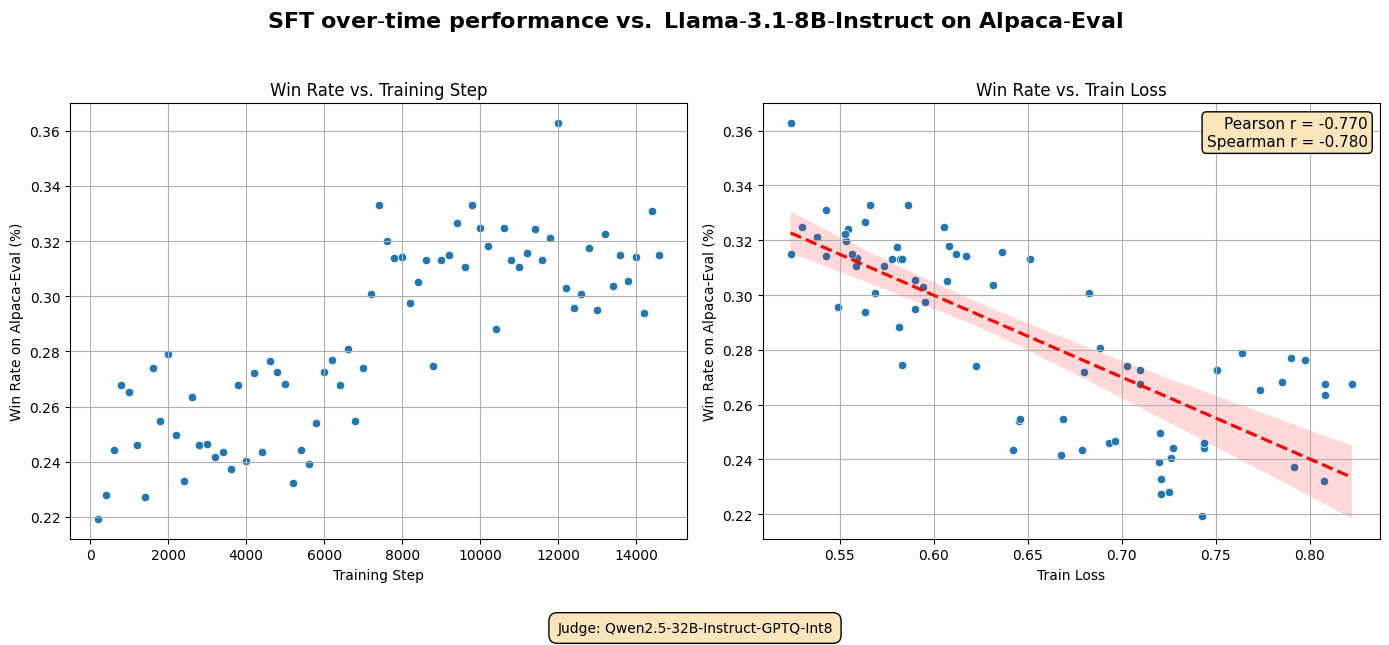

In [67]:
from scipy.stats import pearsonr, spearmanr

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- Plot 1: Winrate vs Step ---
x1 = over_time_df["step"]
y1 = over_time_df["winrate"]

# Scatter plot only for steps
sns.scatterplot(
    data=over_time_df,
    x="step",
    y="winrate",
    ax=axes[0]
)

axes[0].set_xlabel("Training Step")
axes[0].set_ylabel("Win Rate on Alpaca-Eval (%)")
axes[0].set_title("Win Rate vs. Training Step")
axes[0].grid(True)

# --- Plot 2: Winrate vs Train Loss ---
x2 = over_time_df["train_loss"]
y2 = over_time_df["winrate"]

# Scatter plot
sns.scatterplot(
    data=over_time_df,
    x="train_loss",
    y="winrate",
    ax=axes[1]
)

# Dashed correlation (regression) line
sns.regplot(
    x=x2,
    y=y2,
    ax=axes[1],
    scatter=False,
    line_kws={"linestyle": "dashed", "color": "red"}
)

# Compute correlations
pearson2, pval_pearson2 = pearsonr(x2, y2)
spearman2, pval_spearman2 = spearmanr(x2, y2)

axes[1].set_xlabel("Train Loss")
axes[1].set_ylabel("Win Rate on Alpaca-Eval (%)")
axes[1].set_title("Win Rate vs. Train Loss")
axes[1].grid(True)

# Add a box with correlation coefficients at the top right
textstr = (
    f"Pearson r = {pearson2:.3f}\n"
    f"Spearman r = {spearman2:.3f}"
)
axes[1].text(
    0.98, 0.97, textstr,
    transform=axes[1].transAxes,
    fontsize=11,
    va='top', ha='right',
    bbox=dict(facecolor='#fbe6bc', edgecolor='black', boxstyle='round,pad=0.3')
)

fig.suptitle(r"$\bf{SFT~over\text{-}time~performance~vs.~Llama\text{-}3.1\text{-}8B\text{-}Instruct~on~Alpaca\text{-}Eval}$", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])

textstr = (
    f"Judge: Qwen2.5-32B-Instruct-GPTQ-Int8"
)
fig.text(
    0.5, -0.04, textstr,
    fontsize=10,
    va='top', ha='center',
    bbox=dict(facecolor='#fbe6bc', edgecolor='black', boxstyle='round,pad=0.6')
)

plt.show()


# Plot final performance

## Filter results

In [17]:
final_results_df = results_df[~results_df["model_A"].str.contains("/model_") & ~results_df["model_B"].str.contains("work")]
final_results_df.head()

,dataset,model_A,model_B,judge_model,num_battles,winrate,num_wins,num_losses,num_ties,preferences,date,user
9,arena-hard,VLLM//home/hk-project-p0024002/fr_ae293/work/h...,VLLM/allenai/Llama-3.1-Tulu-3-8B-SFT,VLLM/Qwen/Qwen2.5-32B-Instruct-GPTQ-Int8,500,0.441000,130,189,181,"[0.5744425168116589, 0.5, 0.42555748318834097,...",2025-10-23T08:42:00.173113,fr_ae293
18,alpaca-eval,VLLM//home/hk-project-p0024002/fr_ae293/work/h...,VLLM/allenai/Llama-3.1-Tulu-3-8B-SFT,VLLM/Qwen/Qwen2.5-32B-Instruct-GPTQ-Int8,805,0.454037,245,319,241,"[0.7685247834990176, 0.5, 0.9370266439430035, ...",2025-10-23T08:39:26.015641,fr_ae293
53,m-arena-hard,VLLM//home/hk-project-p0024002/fr_ae293/work/h...,VLLM/allenai/Llama-3.1-Tulu-3-8B-SFT,VLLM/Qwen/Qwen2.5-32B-Instruct-GPTQ-Int8,11500,0.454478,2814,3861,4825,"[0.5, 0.5, 0.7109495026250039, 0.5, 0.57444251...",2025-10-23T09:21:57.687123,fr_ae293


## Plot

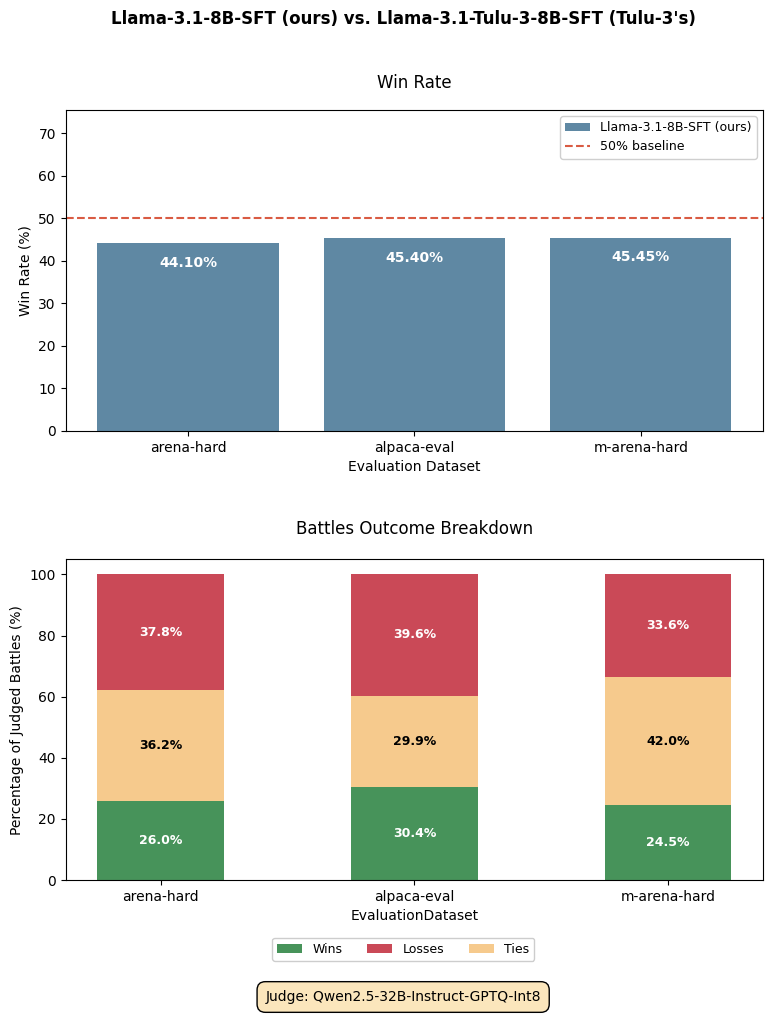

In [68]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import numpy as np

# Prepare data
datasets = final_results_df["dataset"]
winrates = final_results_df["winrate"] * 100
sft_models = final_results_df["model_A"]

# Compute num_wins, num_losses, num_ties percentages
A_wins   = final_results_df['num_wins'].to_numpy()
A_losses = final_results_df['num_losses'].to_numpy()
A_ties   = final_results_df['num_ties'].to_numpy()
totals   = (A_wins + A_losses + A_ties).astype(float)
totals[totals == 0] = 1
A_wins_perc   = A_wins / totals * 100
A_losses_perc = A_losses / totals * 100
A_ties_perc   = A_ties / totals * 100

def percent_fmt(v):
    return f"{v:.1f}%"

n = len(datasets)
x = np.arange(n)
bar_width = 0.5

# --- Change: make subplots vertical ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 10), gridspec_kw={"hspace": 0.4})

# ---- Subplot 1: Barplot of Win Rates ----
bars = ax1.bar(datasets, winrates, color='#5f88a3', label='Llama-3.1-8B-SFT')

# Add baseline winrate line at 50% with red-ish color
ax1.axhline(50, color='#d95b43', linestyle='dashed', linewidth=1.5, label='50% baseline')

ax1.set_ylabel("Win Rate (%)")
ax1.set_xlabel("Evaluation Dataset")
ax1.set_xticks(range(len(datasets)))
ax1.set_xticklabels(datasets, rotation=0, ha='center')

ax1.set_title(
    "Win Rate",
    fontsize=12,
    pad=16
)

# Annotate each bar with its winrate value *inside* the bar (to avoid overlapping the dashed line)
for i, v in enumerate(winrates):
    if v > 8:
        ax1.text(
            i,
            v - 3,
            f"{v/100:.2%}",
            ha='center',
            va='top',
            fontsize=10,
            color='white',
            fontweight='bold'
        )
    else:
        ax1.text(
            i,
            v + 1,
            f"{v/100:.2%}",
            ha='center',
            va='bottom',
            fontsize=10,
            color='black',
            fontweight='bold'
        )

ymax = min(100, winrates.max() + 30)
ax1.set_ylim(0, ymax)

handles = [
    Patch(facecolor='#5f88a3', edgecolor='none', label='Llama-3.1-8B-SFT (ours)'),
    Line2D([0], [0], color='#d95b43', linestyle='dashed', linewidth=1.5, label='50% baseline')
]
ax1.legend(handles=handles, loc='upper right', fontsize=9, framealpha=0.93)

# ---- Subplot 2: Stacked barplot for Wins/Losses/Ties ----

win_col   = "#47935a"
loss_col  = "#ca4957"
tie_col   = "#f6ca8d"

A_bars = ax2.bar(
    x, 
    A_wins_perc, 
    bar_width, 
    color=win_col, 
    zorder=2,
    label='Wins'
)
A_bars2 = ax2.bar(
    x, 
    A_ties_perc, 
    bar_width, 
    bottom=A_wins_perc, 
    color=tie_col, 
    zorder=2,
    label='Ties'
)
A_bars3 = ax2.bar(
    x, 
    A_losses_perc, 
    bar_width, 
    bottom=A_wins_perc + A_ties_perc, 
    color=loss_col, 
    zorder=2,
    label='Losses'
)

def annotate_bar(bar_container, values, y_offset=0, color='white', size=9):
    for bar, val in zip(bar_container, values):
        if val > 0:
            perc = percent_fmt(val)
            ax2.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_y() + bar.get_height() / 2 + y_offset,
                perc,
                ha='center', va='center',
                color=color, fontsize=size, fontweight='bold'
            )

annotate_bar(A_bars,   A_wins_perc,   color='white')
annotate_bar(A_bars2,  A_ties_perc,   color='black')
annotate_bar(A_bars3,  A_losses_perc, color='white')

handles_stacked = [
    Patch(facecolor=win_col,  edgecolor='none', label='Wins'),
    Patch(facecolor=loss_col, edgecolor='none', label='Losses'),
    Patch(facecolor=tie_col,  edgecolor='none', label='Ties'),
]
ax2.legend(handles=handles_stacked, ncol=3, loc='lower center', bbox_to_anchor=(0.5, 0.02), fontsize=9, framealpha=0.97, borderaxespad=0.75, bbox_transform=fig.transFigure)

ax2.set_xticks(x)
ax2.set_xticklabels(datasets)
ax2.set_ylabel('Percentage of Judged Battles (%)')
ax2.set_xlabel('EvaluationDataset')
ax2.set_title("Battles Outcome Breakdown", pad=18)

fig.suptitle("Llama-3.1-8B-SFT (ours) vs. Llama-3.1-Tulu-3-8B-SFT (Tulu-3's)", fontsize=12, weight='bold', y=0.98)

textstr = (
    f"Judge: Qwen2.5-32B-Instruct-GPTQ-Int8"
)
fig.text(
    0.5, 0.00, textstr,
    fontsize=10,
    va='top', ha='center',
    bbox=dict(facecolor='#fbe6bc', edgecolor='black', boxstyle='round,pad=0.6')
)

plt.show()


### Final comparison: Stacked Barplot of Wins, Losses, and Ties for Both Models

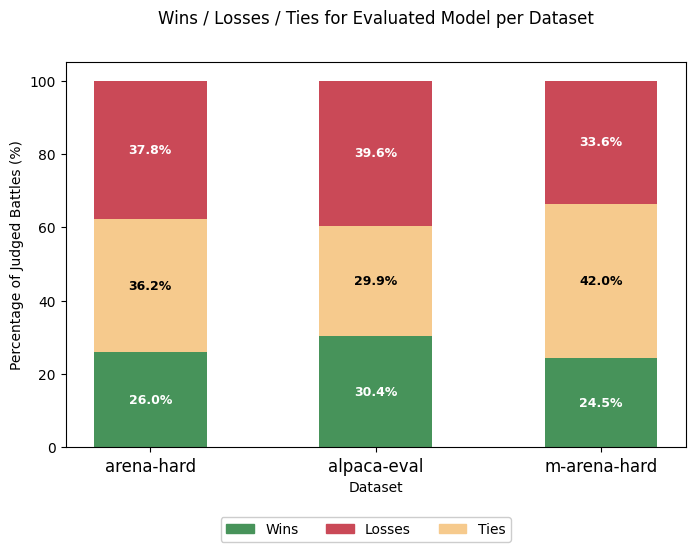

In [20]:
import numpy as np

datasets = final_results_df['dataset'].tolist()
n = len(datasets)

# Wins, losses, ties for model A (the evaluated model, versus baseline)
A_wins   = final_results_df['num_wins'].to_numpy()
A_losses = final_results_df['num_losses'].to_numpy()
A_ties   = final_results_df['num_ties'].to_numpy()

# Total judgements per dataset
totals   = (A_wins + A_losses + A_ties).astype(float)
totals[totals == 0] = 1  # Avoid division by zero

# Convert to percentages
A_wins_perc   = A_wins / totals * 100
A_losses_perc = A_losses / totals * 100
A_ties_perc   = A_ties / totals * 100

def percent_fmt(v):
    return f"{v:.1f}%"

x = np.arange(n)
bar_width = 0.5

fig, ax = plt.subplots(figsize=(max(8, n*1.3), 5))

# Colors
win_col   = "#47935a"
loss_col  = "#ca4957"
tie_col   = "#f6ca8d"

# Stacked bars for model A only (per dataset)
A_bars = ax.bar(
    x, 
    A_wins_perc, 
    bar_width, 
    color=win_col, 
    zorder=2,
    label='Wins'
)
A_bars2 = ax.bar(
    x, 
    A_ties_perc, 
    bar_width, 
    bottom=A_wins_perc, 
    color=tie_col, 
    zorder=2,
    label='Ties'
)
A_bars3 = ax.bar(
    x, 
    A_losses_perc, 
    bar_width, 
    bottom=A_wins_perc + A_ties_perc, 
    color=loss_col, 
    zorder=2,
    label='Losses'
)

# Annotate bars with percentages
def annotate_bar(bar_container, values, y_offset=0, color='white', size=9):
    for bar, val in zip(bar_container, values):
        if val > 0:
            perc = percent_fmt(val)
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_y() + bar.get_height() / 2 + y_offset,
                perc,
                ha='center', va='center',
                color=color, fontsize=size, fontweight='bold'
            )

annotate_bar(A_bars,   A_wins_perc,   color='white')
annotate_bar(A_bars2,  A_ties_perc,   color='black')
annotate_bar(A_bars3,  A_losses_perc, color='white')

# Legend for outcomes
handles = [
    plt.Rectangle((0,0),1,1, color=win_col, label='Wins'),
    plt.Rectangle((0,0),1,1, color=loss_col, label='Losses'),
    plt.Rectangle((0,0),1,1, color=tie_col,  label='Ties'),
]
legend1 = ax.legend(handles=handles, ncol=3, loc='lower center', bbox_to_anchor=(0.5, -0.1), framealpha=0.97, borderaxespad=0.75, bbox_transform=fig.transFigure)

# X-axis: Dataset names directly as labels
ax.set_xticks(x)
ax.set_xticklabels(datasets, fontsize=12)

ax.set_title("Llama-3.1-8B-SFT (ours) vs. Llama-3.1-Tulu-3-8B-SFT (Tulu-3's)", pad=28)
ax.set_ylabel('Percentage of Judged Battles (%)')
ax.set_xlabel('Dataset')

plt.show()
